
Training ensemble model, size: 1

Training ensemble model, size: 3

Training ensemble model, size: 5

Training ensemble model, size: 10


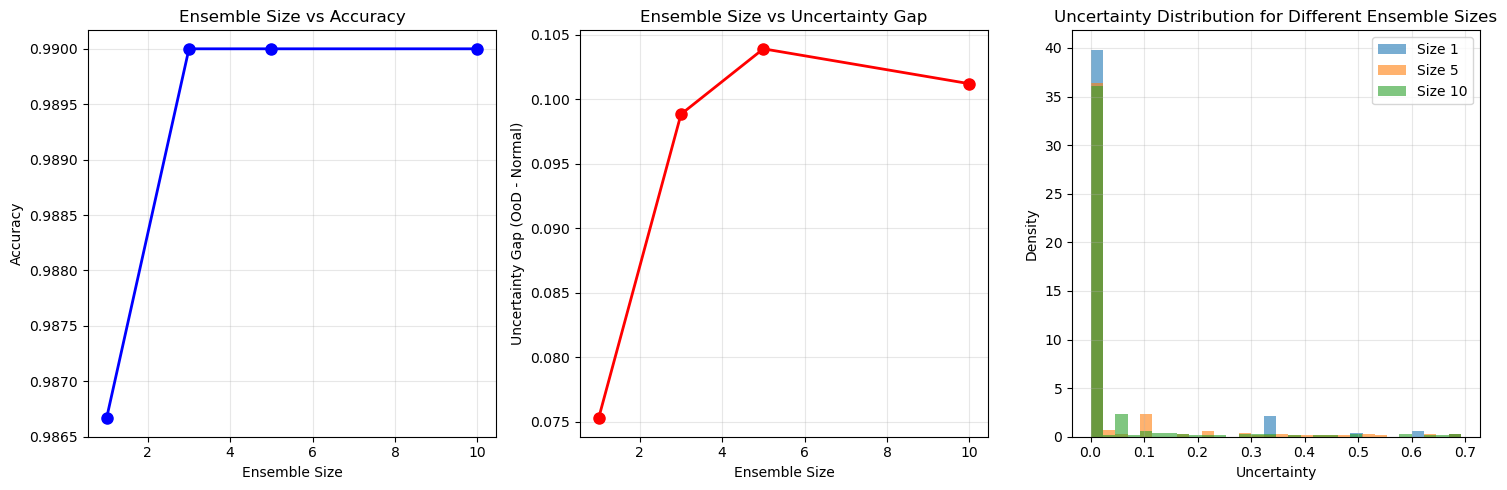


Deep Ensemble OoD Evaluation Results Summary
Ensemble Size  1: Accuracy=0.9867, Normal Sample Uncertainty=0.0189, OoD Sample Uncertainty=0.0942, Gap=0.0753
Ensemble Size  3: Accuracy=0.9900, Normal Sample Uncertainty=0.0172, OoD Sample Uncertainty=0.1161, Gap=0.0988
Ensemble Size  5: Accuracy=0.9900, Normal Sample Uncertainty=0.0185, OoD Sample Uncertainty=0.1224, Gap=0.1039
Ensemble Size 10: Accuracy=0.9900, Normal Sample Uncertainty=0.0175, OoD Sample Uncertainty=0.1187, Gap=0.1012


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

def deep_ensemble_ood_evaluation():
    """
    Evaluate uncertainty of OoD samples using deep ensemble methods
    
    Input: fastship_dataset.csv file
    Output: Uncertainty evaluation results and visualizations for different ensemble sizes
    Function: Analyze the impact of ensemble size on OoD detection performance
    """
    # Load data
    data = pd.read_csv('fastship_dataset.csv')
    X = data.drop('label', axis=1)
    y = data['label']
    
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    # Define different ensemble sizes
    ensemble_sizes = [1, 3, 5, 10]
    results = []
    
    for n_estimators in ensemble_sizes:
        print(f"\nTraining ensemble model, size: {n_estimators}")
        
        # Create multiple models for ensemble
        models = []
        for i in range(n_estimators):
            model = RandomForestClassifier(
                n_estimators=10,  # Use smaller number of trees for faster training
                max_depth=5,
                random_state=42 + i
            )
            model.fit(X_train, y_train)
            models.append(model)
        
        # Calculate uncertainty of ensemble predictions
        all_probs = []
        for model in models:
            probs = model.predict_proba(X_test)
            all_probs.append(probs)
        
        # Calculate average prediction probabilities and uncertainty (using entropy)
        avg_probs = np.mean(all_probs, axis=0)
        uncertainties = -np.sum(avg_probs * np.log(avg_probs + 1e-8), axis=1)
        
        # Calculate prediction results
        ensemble_predictions = np.argmax(avg_probs, axis=1)
        accuracy = accuracy_score(y_test, ensemble_predictions)
        
        # Separate uncertainties for normal and OoD samples
        normal_uncertainty = uncertainties[y_test == 0]
        ood_uncertainty = uncertainties[y_test == 1]
        
        results.append({
            'ensemble_size': n_estimators,
            'accuracy': accuracy,
            'normal_uncertainty_mean': np.mean(normal_uncertainty),
            'ood_uncertainty_mean': np.mean(ood_uncertainty),
            'uncertainty_gap': np.mean(ood_uncertainty) - np.mean(normal_uncertainty),
            'uncertainties': uncertainties
        })
    
    # Visualize results
    plt.figure(figsize=(15, 5))
    
    # Subplot 1: Accuracy vs ensemble size
    plt.subplot(1, 3, 1)
    sizes = [r['ensemble_size'] for r in results]
    accuracies = [r['accuracy'] for r in results]
    plt.plot(sizes, accuracies, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Ensemble Size')
    plt.ylabel('Accuracy')
    plt.title('Ensemble Size vs Accuracy')
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Uncertainty gap vs ensemble size
    plt.subplot(1, 3, 2)
    uncertainty_gaps = [r['uncertainty_gap'] for r in results]
    plt.plot(sizes, uncertainty_gaps, 'ro-', linewidth=2, markersize=8)
    plt.xlabel('Ensemble Size')
    plt.ylabel('Uncertainty Gap (OoD - Normal)')
    plt.title('Ensemble Size vs Uncertainty Gap')
    plt.grid(True, alpha=0.3)
    
    # Subplot 3: Uncertainty distribution for different ensemble sizes
    plt.subplot(1, 3, 3)
    for i, result in enumerate(results):
        if result['ensemble_size'] in [1, 5, 10]:  # Select some representative sizes
            plt.hist(result['uncertainties'], bins=30, alpha=0.6, 
                    label=f'Size {result["ensemble_size"]}', density=True)
    plt.xlabel('Uncertainty')
    plt.ylabel('Density')
    plt.title('Uncertainty Distribution for Different Ensemble Sizes')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('ensemble_ood_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print results summary
    print("\n" + "="*50)
    print("Deep Ensemble OoD Evaluation Results Summary")
    print("="*50)
    for result in results:
        print(f"Ensemble Size {result['ensemble_size']:2d}: "
              f"Accuracy={result['accuracy']:.4f}, "
              f"Normal Sample Uncertainty={result['normal_uncertainty_mean']:.4f}, "
              f"OoD Sample Uncertainty={result['ood_uncertainty_mean']:.4f}, "
              f"Gap={result['uncertainty_gap']:.4f}")
    
    return results

# Execute OoD evaluation
ood_results = deep_ensemble_ood_evaluation()